In [124]:
#import all packages that we may need

import sys 
import numpy as np                                                                   # linear algebra
from scipy.stats import randint
import pandas as pd                                                                  # data processing
import matplotlib.pyplot as plt                                                      # this is used for the plot the graph 
import seaborn as sns                                                                # used for plot interactive graph. 
from sklearn.model_selection import train_test_split                                 # to split the data into two parts
from sklearn.model_selection import KFold 
from sklearn.model_selection import TimeSeriesSplit                                           # use for cross validation
from sklearn import preprocessing                                                    # for normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline                                                # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics                                                          # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## for Modeling and forecasting:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from pandas import concat
import matplotlib.dates as md
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-v0_8-darkgrid')
color_pal = sns.color_palette()
import xgboost as xgb

#Warning configuration
import warnings
warnings.filterwarnings('once')

In [123]:
#pip install statsmodels

     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
      --------------------------------------- 0.2/9.2 MB 4.6 MB/s eta 0:00:02
     - -------------------------------------- 0.4/9.2 MB 6.3 MB/s eta 0:00:02
     --- ------------------------------------ 0.9/9.2 MB 6.8 MB/s eta 0:00:02
     ----- ---------------------------------- 1.2/9.2 MB 7.1 MB/s eta 0:00:02
     ------- -------------------------------- 1.7/9.2 MB 7.6 MB/s eta 0:00:01
     --------- ------------------------------ 2.2/9.2 MB 8.4 MB/s eta 0:00:01
     ----------- ---------------------------- 2.8/9.2 MB 8.8 MB/s eta 0:00:01
     ------------ --------------------------- 2.9/9.2 MB 8.2 MB/s eta 0:00:01
     -------------- ------------------------- 3.4/9.2 MB 8.3 MB/s eta 0:00:01
     ---------------- ----------------------- 3.8/9.2 MB 8.4 MB/s eta 0:00:01
     ------------------ --------------------- 4.3/9.2 MB 8.9 MB/s eta 0:00:01
     --------------------- ------------------ 4.8/9.2 MB 8.8 MB/s eta 0


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\dbansal\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\dbansal\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\dbansal\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


In [100]:
#%% Loading all datasets (some appliances)
df = pd.read_csv("C:/Bansal Data/Drishti Data/Self/iCode/Projects/AI project/Merged data/Boiler/Merged data for boilers.csv", parse_dates = ['timestamp'], infer_datetime_format = True, index_col = False)
df.head(4)

C:\Users\dbansal\AppData\Local\Temp\ipykernel_13368\73577525.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("C:/Bansal Data/Drishti Data/Self/iCode/Projects/AI project/Merged data/Boiler/Merged data for boilers.csv", parse_dates = ['timestamp'], infer_datetime_format = True, index_col = False)


,Unnamed: 0,timestamp,power
0,0,2020-09-23 22:13:53+00:00,0.0
1,1,2020-09-23 22:13:54+00:00,0.0
2,2,2020-09-23 22:13:55+00:00,0.0
3,3,2020-09-23 22:13:56+00:00,0.0


In [101]:
print(f"Number of rows with missing values: {df.isnull().any(axis = 1).mean()}")

Number of rows with missing values: 0.0


In [102]:
# Stating the numbers for the appliance

print("The length of the data is: ", len(df))
print("The size of the data is: ", df.size)
print("The column list is: ", df.columns)
highest_power = df['power'].max()
print("The highest power in Watts for Boiler: ", highest_power)

The length of the data is:  7776002
The size of the data is:  23328006
The column list is:  Index(['Unnamed: 0', 'timestamp', 'power'], dtype='object')
The highest power in Watts for Boiler:  2664.0


In [103]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values. (in this case, there is no NaN, but stil for the future references)
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [105]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df = df.drop(["Unnamed: 0"], axis = 1)
startTimestamp = df.index[1]
endTimestamp = df.index[-1]
duration = endTimestamp - startTimestamp
print("The duration of the period within the merged data for boiler: ", duration)
"""
df.plot(y  ='power', 
        style = '.', 
        figsize = (15, 5), 
        color = color_pal[0], 
        title = 'Boiler Power Use in Watts')
plt.show()
"""

The duration of the period within the merged data for boiler:  103 days 19:56:54


"\ndf.plot(y  ='power', \n        style = '.', \n        figsize = (15, 5), \n        color = color_pal[0], \n        title = 'Boiler Power Use in Watts')\nplt.show()\n"

In [106]:
# Selecting data from 18th Feb 2021 to 20th Mar 2021. boiler_226 is the only dataset that has data records in power column.

df = df['2021-02-18 05:28:53+00:00':'2021-03-20 05:28:52+00:00']

In [107]:
# After selecting the date range, state the numbers

print("The length of the data is: ", len(df))
print("The size of the data is: ", df.size)
print("The column list is: ", df.columns)
highest_power = df['power'].max()
print("The highest power in Watts for Boiler: ", highest_power)

The length of the data is:  2592000
The size of the data is:  2592000
The column list is:  Index(['power'], dtype='object')
The highest power in Watts for Boiler:  2664.0


In [108]:
unique_power = df.groupby(df['power']).size()
print(unique_power)

power
0.00       577566
0.20            1
0.25          137
0.50         1714
0.60            6
            ...  
2630.00        51
2642.00        20
2647.50         1
2653.00        20
2664.00         3
Length: 372, dtype: int64


Until here, above are basically the description of the data.

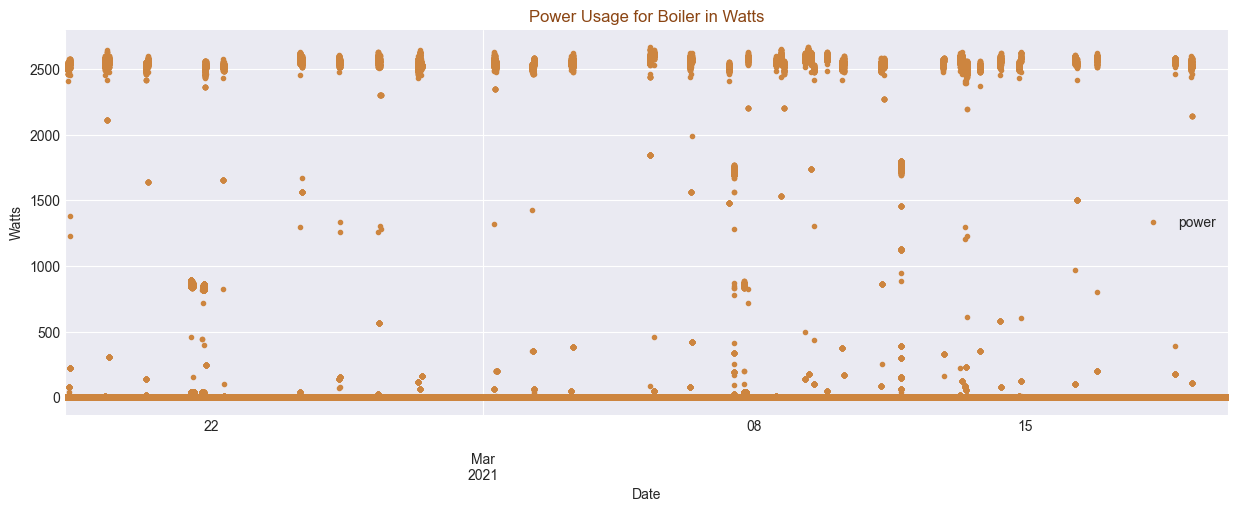

In [131]:
# Scatter plot instead of line bar graph to indicate the values.

df.plot(y ='power', style = '.', figsize = (15, 5), color = 'peru')
plt.xlabel("Date")
plt.ylabel("Watts")
plt.title("Power Usage for Boiler in Watts", color = 'saddlebrown')
plt.show()

Although the data is at 30 minute intervals, the aim is to create a model capable of predicting hourly electricity demand, so the data needs to be aggregated. This type of transformation can be done very quickly by combining the Pandas time type index and its resample() method.

It is very important to use the closed = 'left' and label  ='right' arguments correctly to avoid introducing future information into the training, leakage. Suppose that values are available for 10:10, 10:30, 10:45, 11:00, 11:12, and 11:30. To obtain the hourly average, the value assigned to 11:00 must be calculated using the values for 10:10, 10:30, and 10:45; and the value assigned to 12:00 must be calculated using the value for 11:00, 11:12 and 11:30.The 11:00 average does not include the 11:00 point value because in reality the value is not available at that exact time.

In [137]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
#data = df.drop(columns = 'timestamp', axis = 1)
data = df.resample(rule = 'H', closed = 'left', label = 'right').mean()
data.head(10)

,power
timestamp,
2021-02-18 06:00:00+00:00,0.512319
2021-02-18 07:00:00+00:00,174.081458
2021-02-18 08:00:00+00:00,47.978472
2021-02-18 09:00:00+00:00,65.224028
2021-02-18 10:00:00+00:00,0.180278
2021-02-18 11:00:00+00:00,0.216319
2021-02-18 12:00:00+00:00,0.214306
2021-02-18 13:00:00+00:00,0.183056
2021-02-18 14:00:00+00:00,0.116389


In [161]:
data.tail(10)

,power,hour_day
timestamp,,
2021-03-19 20:00:00+00:00,1.0,21
2021-03-19 21:00:00+00:00,1.0,22
2021-03-19 22:00:00+00:00,1.0,23
2021-03-19 23:00:00+00:00,1.0,24
2021-03-20 00:00:00+00:00,1.0,1
2021-03-20 01:00:00+00:00,1.0,2
2021-03-20 02:00:00+00:00,1.0,3
2021-03-20 03:00:00+00:00,1.0,4
2021-03-20 04:00:00+00:00,1.0,5


In [162]:
data.shape

(720, 2)

720 records is way too low to predict, but let's go on.

The dataset starts on 2021-02-18 06:00:00 and ends on 2021-03-20 05:00:00. The first 10 and the last 10 records are discarded so that it starts on 2012-01-01 00:00:00 and ends on 2014-12-30 23:00:00. In addition, in order to optimize the hyperparameters of the model and evaluate its predictive ability, the data is divided into 3 sets, training, validation and test.

In [166]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2021-02-18 01:00:00': '2021-03-20 05:00:00'].copy()
end_train = '2021-02-20 23:59:00'
end_validation = '2021-03-15 05:00:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2021-02-18 06:00:00+00:00 --- 2021-02-20 23:00:00+00:00  (n=66)
Validation dates : 2021-02-21 00:00:00+00:00 --- 2021-03-15 05:00:00+00:00  (n=534)
Test dates       : 2021-03-15 05:00:00+00:00 --- 2021-03-20 05:00:00+00:00  (n=121)


When building a forecasting model, it may be useful to plot the time series values. This allows patterns such as trends and seasonality to be identified.

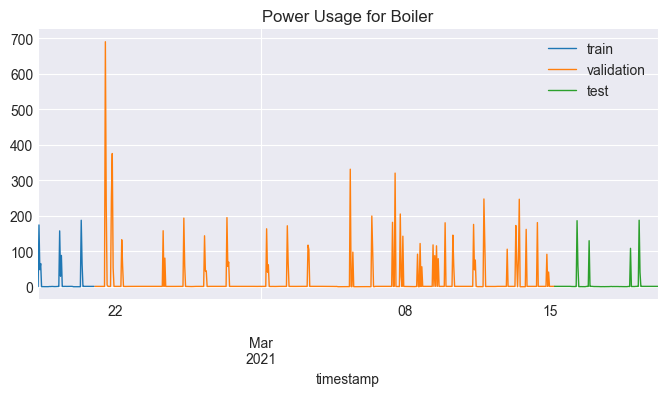

In [167]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data_train.power.plot(ax = ax, label = 'train', linewidth = 1)
data_val.power.plot(ax = ax, label = 'validation', linewidth = 1)
data_test.power.plot(ax = ax, label = 'test', linewidth = 1)
ax.set_title('Power Usage for Boiler')
ax.legend()

The graph above shows that power usage has an annual seasonality. There is a peak around 22nd Feb and very pronounced peaks in usage from begining of train and end of train.

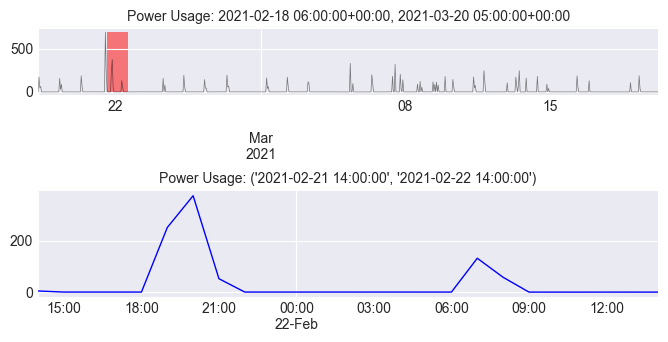

In [146]:
# Zooming time series chart
# ==============================================================================
zoom = ('2021-02-21 14:00:00','2021-02-22 14:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
data.power.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.power)
max_y = max(data.power)
main_ax.fill_between(zoom, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]].power.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Power Usage: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Power Usage: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

When the time series are zoomed in, a clear weekly seasonality can be seen, with higher consumption during the working hours and lower consumption at weekends. There is also a clear correlation between the consumption of each hour and that of the previous day.

Text(0.5, 0.98, '')

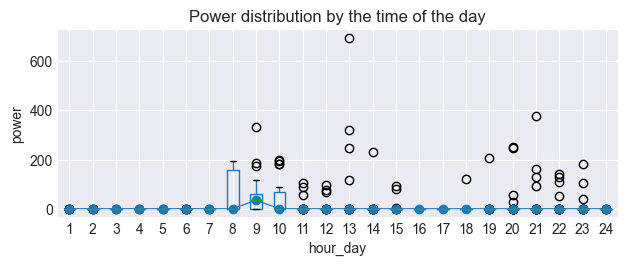

In [168]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data['hour_day'] = data.index.hour + 1
data.boxplot(column = 'power', by = 'hour_day', ax = ax)
data.groupby('hour_day')['power'].median().plot(style = 'o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('power')
ax.set_title('Power distribution by the time of the day')
fig.suptitle('')

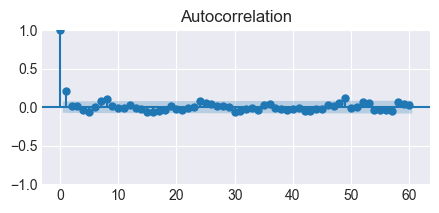

In [125]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data.power, ax=ax, lags=60)
plt.show()

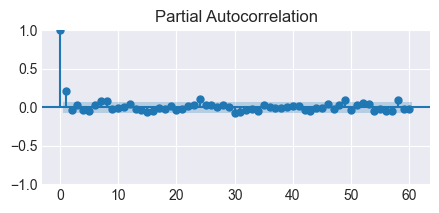

In [126]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data.power, ax=ax, lags=60)
plt.show()

In [169]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:end_validation, 'power'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-02-18 06:00:00+0000', tz='UTC'), Timestamp('2021-03-15 05:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-02 16:28:04 
Last fit date: 2023-08-02 16:28:04 
Skforecast version: 0.9.1 
Python version: 3.11.4 
Forecaster id: None 

In [170]:
# Backtest

metric, predictions = backtesting_forecaster(forecaster = forecaster, y = data['power'], steps = 24, metric = 'mean_absolute_error', initial_train_size = len(data.loc[:end_validation]),
                          refit  = False, n_jobs = 'auto', verbose = True, show_progress = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 600
Number of observations used for backtesting: 120
    Number of folds: 5
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2021-02-18 06:00:00+00:00 -- 2021-03-15 05:00:00+00:00  (n=600)
    Validation: 2021-03-15 06:00:00+00:00 -- 2021-03-16 05:00:00+00:00  (n=24)
Fold: 1
    Training:   2021-02-18 06:00:00+00:00 -- 2021-03-15 05:00:00+00:00  (n=600)
    Validation: 2021-03-16 06:00:00+00:00 -- 2021-03-17 05:00:00+00:00  (n=24)
Fold: 2
    Training:   2021-02-18 06:00:00+00:00 -- 2021-03-15 05:00:00+00:00  (n=600)
    Validation: 2021-03-17 06:00:00+00:00 -- 2021-03-18 05:00:00+00:00  (n=24)
Fold: 3
    Training:   2021-02-18 06:00:00+00:00 -- 2021-03-15 05:00:00+00:00  (n=600)
    Validation: 2021-03-18 06:00:00+00:00 -- 2021-03-19 05:00:00+00:00  (n=24)
Fold: 4
    Trainin

100%|██████████| 5/5 [00:00<00:00, 278.75it/s]


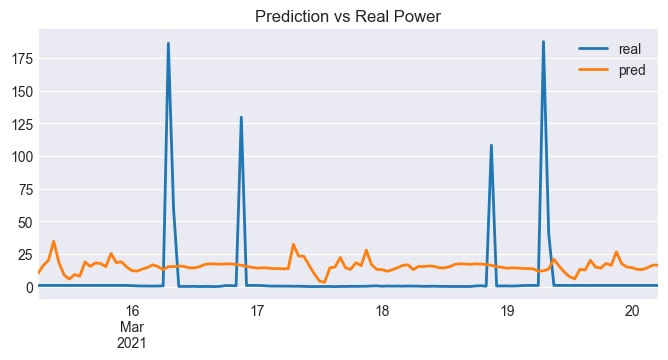

In [171]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'power'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Real Power')
ax.legend()

In [172]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 19.378805434844594


The trained ForecasterAutoreg object used the first 24 lags and a Ridge model with the default hyperparameters. However, there is no reason why these values are the most appropriate.

To identify the best combination of lags and hyperparameters, a Grid Search with validation by Backtesting is used. This process consists of training a model with different combinations of hyperparameters and lags and evaluating its predictive capacity. In the search process, it is important to evaluate the models using only the validation data and not to include the test data, which is only used to evaluate the final model.

In [173]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'power'],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:end_train]),
                   refit              = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 30.


lags grid: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 100000.0}
  Backtesting metric: 21.55527434813011



In [174]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_absolute_error,alpha
9,"[1, 2, 3, 4, 5]",{'alpha': 100000.0},21.555274,100000.000000
8,"[1, 2, 3, 4, 5]",{'alpha': 12915.496650148827},21.556531,12915.496650
7,"[1, 2, 3, 4, 5]",{'alpha': 1668.1005372000557},21.565754,1668.100537
6,"[1, 2, 3, 4, 5]",{'alpha': 215.44346900318823},21.623158,215.443469
5,"[1, 2, 3, 4, 5]",{'alpha': 27.825594022071257},21.813083,27.825594
4,"[1, 2, 3, 4, 5]",{'alpha': 3.593813663804626},21.907685,3.593814
3,"[1, 2, 3, 4, 5]",{'alpha': 0.46415888336127775},21.924668,0.464159
2,"[1, 2, 3, 4, 5]",{'alpha': 0.05994842503189409},21.926888,0.059948
1,"[1, 2, 3, 4, 5]",{'alpha': 0.007742636826811269},21.927175,0.007743
0,"[1, 2, 3, 4, 5]",{'alpha': 0.001},21.927212,0.001000


The best results are obtained by using the lags [1, 2, 3, 4, 5] and a Ridge configuration {'alpha': 12915.50}. By specifying return_best = True in the grid_search_forecaster() function. The forecaster object is automatically retrained at the end of the process with the best configuration found and the full dataset (train + validation).

In [175]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=100000.0, random_state=123) 
Lags: [1 2 3 4 5] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 5 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-02-18 06:00:00+0000', tz='UTC'), Timestamp('2021-03-15 05:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 100000.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-02 16:29:23 
Last fit date: 2023-08-02 16:29:25 
Skforecast version: 0.9.1 
Python version: 3.11.4 
Forecaster id: None 

100%|██████████| 5/5 [00:00<00:00, 226.01it/s]


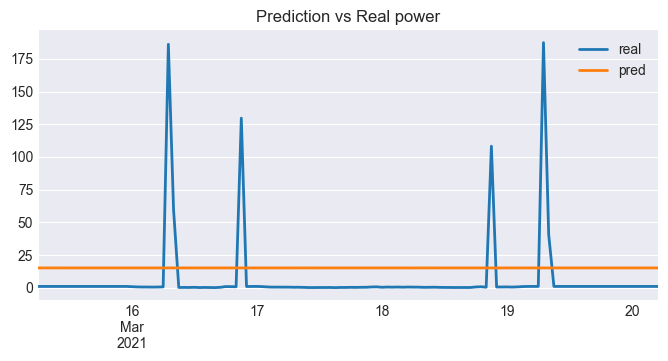

In [176]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['power'],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'power'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Real power')
ax.legend()

??? graph above seems to be misleading.

In [177]:
# Backtest with test data and intervals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['power'],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 500,
                          in_sample_residuals = True,
                          n_jobs             = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )

print('Backtesting metric:', metric)
predictions.head(5)

100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

Backtesting metric: 18.941856635091018


,pred,lower_bound,upper_bound
2021-03-15 06:00:00+00:00,15.133327,0.412501,44.879981
2021-03-15 07:00:00+00:00,15.150288,0.294677,1.472273
2021-03-15 08:00:00+00:00,15.150739,0.318972,1.184734
2021-03-15 09:00:00+00:00,15.152493,0.289734,41.354629
2021-03-15 10:00:00+00:00,15.149393,0.276290,1.185014


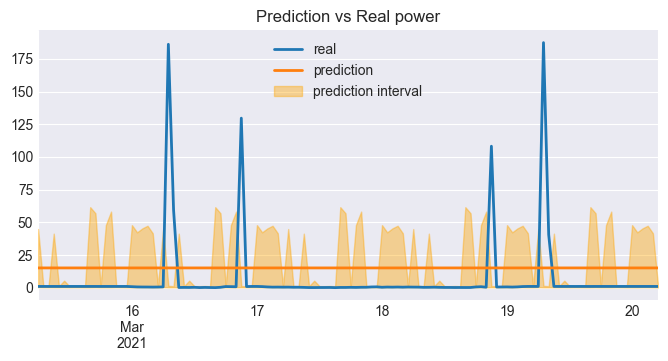

In [178]:
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'power'].plot(linewidth=2, label='real', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Real power')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha = 0.4,
    color = 'orange',
    label = 'prediction interval' 
)
ax.legend()

Something is wrong with prediction value.

In [180]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where((data.loc[end_validation:, 'power'] >= predictions["lower_bound"].values()) & (data.loc[end_validation:, 'power'] <= predictions["upper_bound"].values()),
                      True, False)

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

TypeError: 'numpy.ndarray' object is not callable

In [181]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.001200
1,lag_2,0.000031
2,lag_3,0.000124
3,lag_4,-0.000220
4,lag_5,-0.000411


As the ForecasterAutoreg object uses scikit-learn models, the importance of predictors can be accessed once they have been trained. If the regressor used is a LinearRegression(), Lasso() or Ridge(), the coefficients of the model reflect their importance. In GradientBoostingRegressor() or RandomForestRegressor() regressors, the importance of the predictors is based on the impurity.

In [187]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=123),
                 steps            = 10, # Steps + gap
                 lags             = 24, # This value will be replaced in the grid search
                 transformer_y    = None,
                 transformer_exog = None
             )

exog = [col for col in data.columns if col.startswith(('hour_day'))]
forecaster.fit(y=data.loc[:end_validation, 'power'], exog=data.loc[:end_validation, exog])

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

results_grid = grid_search_forecaster(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_validation, 'power'],
                   exog                  = data.loc[:end_validation, exog],
                   steps                 = 8,
                   metric                = 'mean_absolute_error',
                   param_grid            = param_grid,
                   lags_grid             = lags_grid,
                   initial_train_size    = len(data.loc[:end_train]) + 2,
                   gap                   = 2,
                   allow_incomplete_fold = True,
                   refit                 = False,
                   return_best           = True,
                   n_jobs                = 'auto',
                   verbose               = False,
                   show_progress         = True
)

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

lags grid:  50%|█████     | 1/2 [00:02<00:02,  2.18s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

lags grid: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47] 
  Parameters: {'max_depth': 4, 'n_estimators': 100}
  Backtesting metric: 20.166661623743735



In [188]:
results_grid

,lags,params,mean_absolute_error,max_depth,n_estimators
4,"[1, 2, 3, 23, 24, 25, 47]","{'max_depth': 4, 'n_estimators': 100}",20.166662,4,100
5,"[1, 2, 3, 23, 24, 25, 47]","{'max_depth': 4, 'n_estimators': 500}",20.166662,4,500
6,"[1, 2, 3, 23, 24, 25, 47]","{'max_depth': 6, 'n_estimators': 100}",20.166662,6,100
7,"[1, 2, 3, 23, 24, 25, 47]","{'max_depth': 6, 'n_estimators': 500}",20.166662,6,500
0,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 100}",21.196955,4,100
1,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 500}",21.196955,4,500
2,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 100}",21.196955,6,100
3,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 500}",21.196955,6,500


In [190]:
# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['power'],
                          exog                  = data[exog],
                          steps                 =  9,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+1,
                          gap                   = 1,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

100%|██████████| 14/14 [00:00<00:00, 133.36it/s]


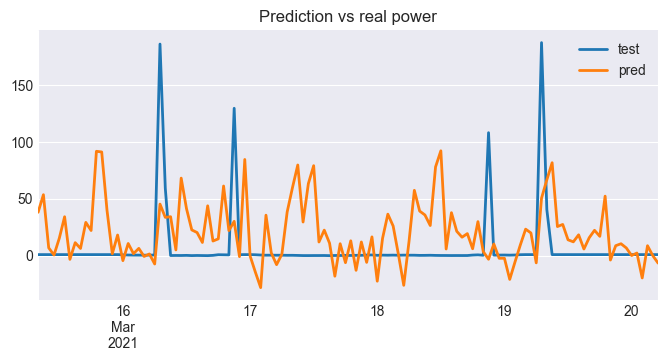

In [191]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'power'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real power')
ax.legend()

In [192]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'power'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")

Backtest error: 26.256098917433732


In this case, using a Gradient Boosting LGBMRegressor model, the direct multi-step strategy generates better results than the recursive strategy with a linear model.

Below is copied from Shaun just to see.

In [193]:
Oneday_df = df.loc[(df.index < '2021-02-19') & (df.index >= '2021-02-18')]
Oneday_df.head(4)
Oneday_df.shape

(66667, 1)

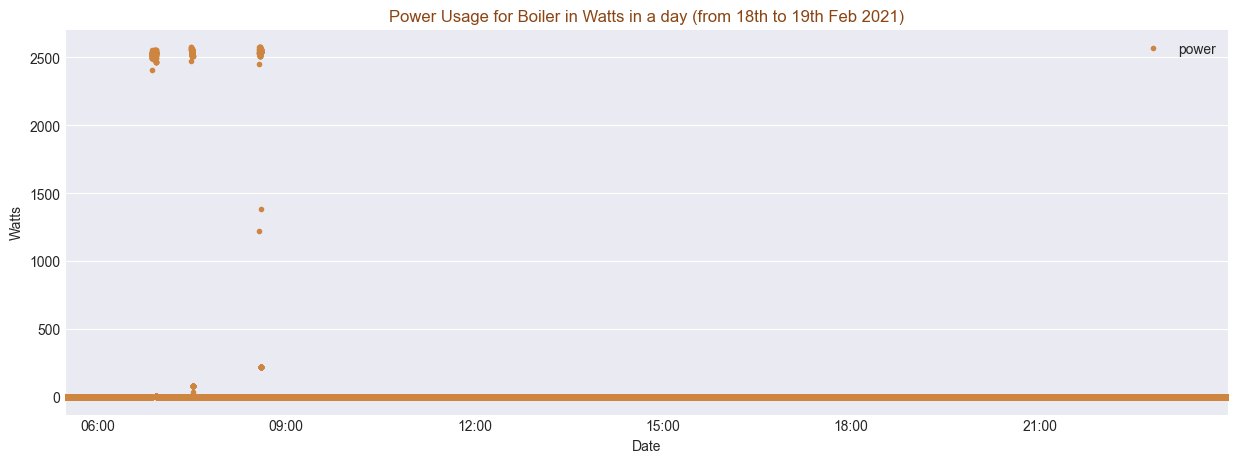

In [194]:
# Scatter plot instead of line bar graph to indicate the values.

Oneday_df.plot(y ='power', style = '.', figsize = (15, 5), color = 'peru')
plt.xlabel("Date")
plt.ylabel("Watts")
plt.title("Power Usage for Boiler in Watts in a day (from 18th to 19th Feb 2021)", color = 'saddlebrown')
plt.show()

In [195]:
# Aggregate from minute to day
mseries = Oneday_df.resample('1h').power.sum()
mseries.head(4)

timestamp
2021-02-18 05:00:00+00:00       956.50
2021-02-18 06:00:00+00:00    626693.25
2021-02-18 07:00:00+00:00    172722.50
2021-02-18 08:00:00+00:00    234806.50
Freq: H, Name: power, dtype: float64

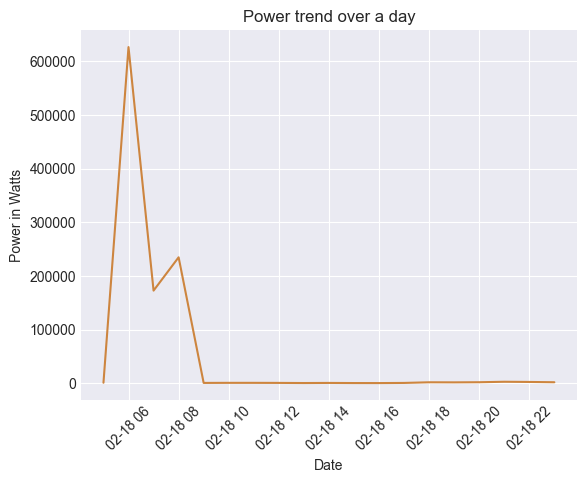

In [196]:
# Power trend over a day
plt.plot(mseries, color = 'peru')
plt.title("Power trend over a day")
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Power in Watts')
plt.show()

In [197]:
# Aggregate from minute to day
df1 = df.resample('30T').sum()
df1.head(4)

,power
timestamp,
2021-02-18 05:00:00+00:00,45.00
2021-02-18 05:30:00+00:00,911.50
2021-02-18 06:00:00+00:00,614.00
2021-02-18 06:30:00+00:00,626079.25


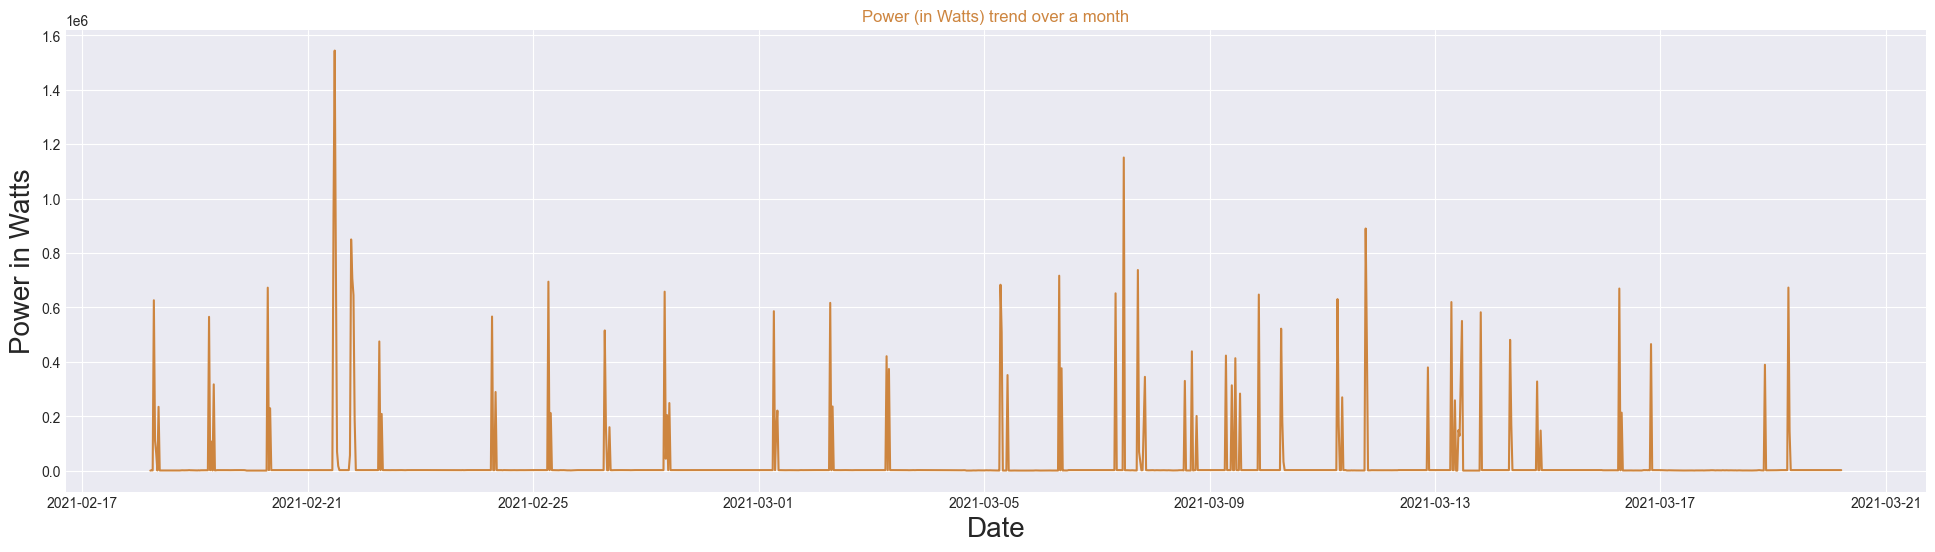

In [198]:
# Power trend over a month
plt.figure(figsize=(24, 6))
plt.plot(df1['power'], color = 'peru')
plt.title("Power (in Watts) trend over a month", color = 'peru')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Power in Watts', fontsize = 20)
plt.legend
plt.show()

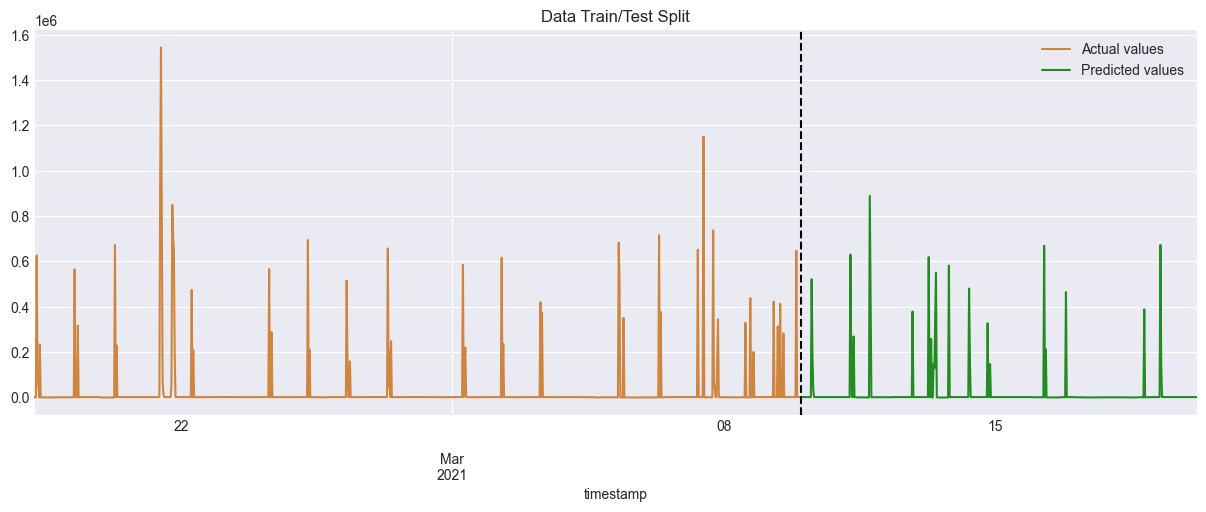

In [199]:
train = df1.loc[df1.index < '2021-03-10']
test = df1.loc[df1.index >= '2021-03-10']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split', color = 'peru')
test.plot(ax = ax, label='Test Set', color = 'forestgreen')
ax.axvline('2021-03-10', color = 'black', ls = '--')
ax.legend(['Actual values', 'Predicted values'])
plt.show()

In [200]:
#Create time series split
Timesplit = TimeSeriesSplit(n_splits = 5, test_size = 5*24*2)
df1 = df1.sort_index()

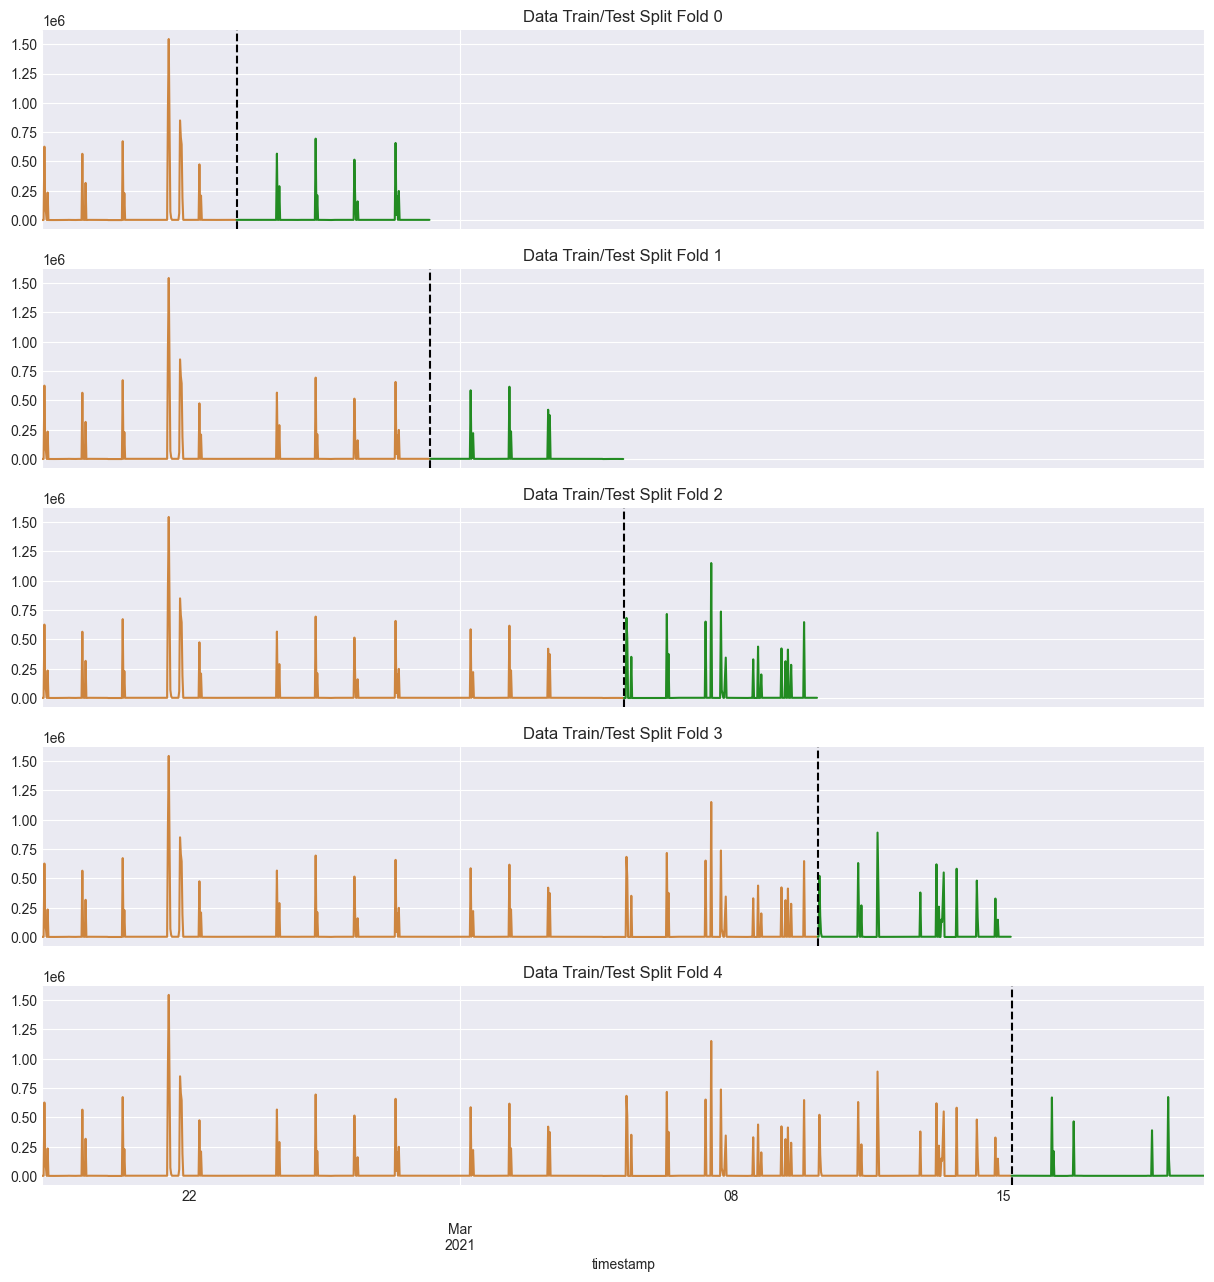

In [201]:
                        
fig, axs = plt.subplots(5, 1, figsize = (15,15), sharex = True)
fold = 0

for train_idx, val_idx in Timesplit.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]
    train['power'].plot(ax = axs[fold], label= 'Actual Values', title = f'Data Train/Test Split Fold {fold}', color = 'peru')
    test['power'].plot(ax = axs[fold], label = 'Predicted Values', color = 'forestgreen')
    axs[fold].axvline(test.index.min(), color = 'black', ls='--')
    fold+=1

In [202]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['Hour'] = df.index.hour
    df['Day'] = df.index.dayofweek
    df['Week'] = pd.Index(df.index.isocalendar().week)
    return df

def add_lags(df):
    target_map = df['power'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('5 days')).map(target_map)
    return df

In [203]:
df1 = create_features(df1)
df1 = add_lags(df1)
df2 = df1
df1.head(4)

,power,Hour,Day,Week,lag1,lag2,lag3
timestamp,,,,,,,
2021-02-18 05:00:00+00:00,45.00,5,3,7,NaN,NaN,NaN
2021-02-18 05:30:00+00:00,911.50,5,3,7,NaN,NaN,NaN
2021-02-18 06:00:00+00:00,614.00,6,3,7,NaN,NaN,NaN
2021-02-18 06:30:00+00:00,626079.25,6,3,7,NaN,NaN,NaN


In [204]:
#data scaling from 0 to 1 of original data
scaler = StandardScaler()
scaler.fit(df1)
scaler1 = MinMaxScaler(feature_range = (0, 1))
scaled1 = scaler.fit_transform(df1)
df1 = pd.DataFrame(scaled1, index = df1.index, columns = df1.columns)

scaler.fit(df2)
scaled2 = scaler.transform(df2)
df2 = pd.DataFrame(scaled2, index = df2.index, columns = df2.columns)

df1.head(4)

,power,Hour,Day,Week,lag1,lag2,lag3
timestamp,,,,,,,
2021-02-18 05:00:00+00:00,-0.216734,-0.938397,-0.024945,-1.627064,NaN,NaN,NaN
2021-02-18 05:30:00+00:00,-0.209266,-0.938397,-0.024945,-1.627064,NaN,NaN,NaN
2021-02-18 06:00:00+00:00,-0.211830,-0.793928,-0.024945,-1.627064,NaN,NaN,NaN
2021-02-18 06:30:00+00:00,5.178944,-0.793928,-0.024945,-1.627064,NaN,NaN,NaN


In [205]:
Timesplit = TimeSeriesSplit(n_splits=5, test_size=24*2*5, gap=24)
df1 = df1.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in Timesplit.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    Features = ['Hour', 'Day', 'lag1']
    Target = 'power'

    X_train = train[Features]
    y_train = train[Target]

    X_test = test[Features]
    y_test = test[Target]

    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 1000, early_stopping_rounds = 50, objective = 'reg:linear',
                           max_depth = 3, learning_rate = 0.01)
    reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.55321	validation_1-rmse:0.92146
[100]	validation_0-rmse:1.15768	validation_1-rmse:0.70033
[166]	validation_0-rmse:1.02894	validation_1-rmse:0.71168
[16:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.25999	validation_1-rmse:0.84663
[100]	validation_0-rmse:0.94503	validation_1-rmse:0.80701
[101]	validation_0-rmse:0.94347	validation_1-rmse:0.80634
[16:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now depr

In [206]:
test['prediction'] = y_pred
df1 = df1.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df1.tail(4)

,power,Hour,Day,Week,lag1,lag2,lag3,prediction
timestamp,,,,,,,,
2021-03-20 03:30:00+00:00,-0.201608,-1.227335,1.002084,1.478366,-0.202514,-0.214002,-0.212699,-0.121359
2021-03-20 04:00:00+00:00,-0.201608,-1.082866,1.002084,1.478366,-0.202514,-0.210625,-0.212699,-0.121359
2021-03-20 04:30:00+00:00,-0.201608,-1.082866,1.002084,1.478366,-0.202514,-0.212754,-0.212699,-0.121359
2021-03-20 05:00:00+00:00,-0.202185,-0.938397,1.002084,1.478366,-0.202514,-0.213871,-0.212699,-0.121359


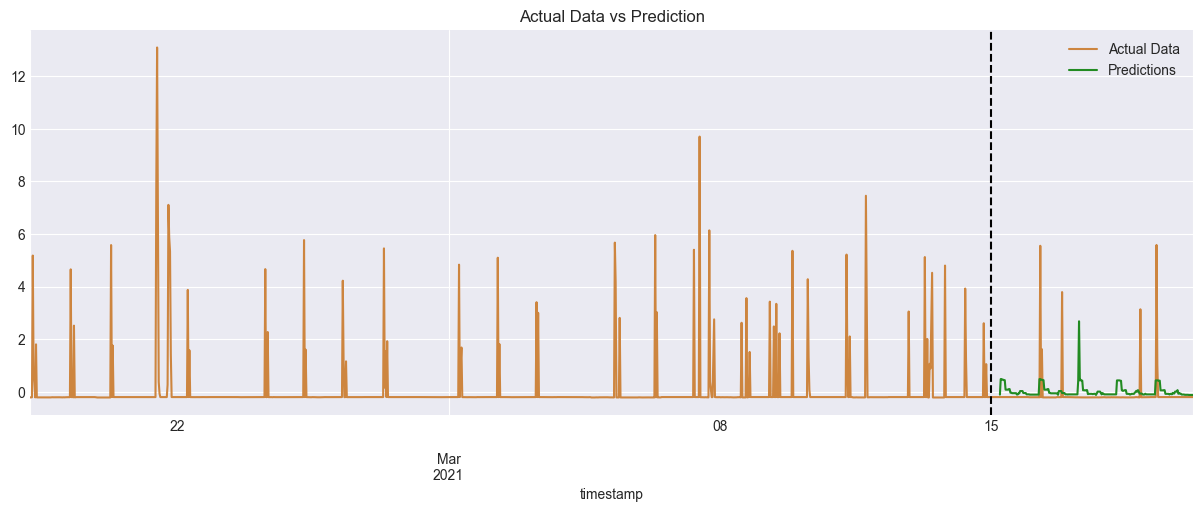

In [207]:
fig, ax = plt.subplots(figsize = (15, 5))
#ax = df1[['power']].plot(figsize = (15,5))
df1.plot(y = 'power', ax = ax, color = 'peru')
df1.plot(y = 'prediction', ax = ax, color = 'forestgreen')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data vs Prediction')
ax.axvline('03-15-2021', color = 'black', ls = '--')
plt.show()

In [208]:
df1['power'] = df1['power'].fillna(0)
df1['prediction'] = df1['prediction'].fillna(0)

score = np.sqrt(mean_squared_error(df1['power'], df1['prediction']))
print(f'RMSE Score on Test Data: {score:0.4f}')

RMSE Score on Test Data: 1.0013


Below is using ExtraTreesClassifier

In [216]:
model_tree = ExtraTreesClassifier()
alpha = data.iloc[:, 1:]
beta = data.iloc[:, 0].astype(int)

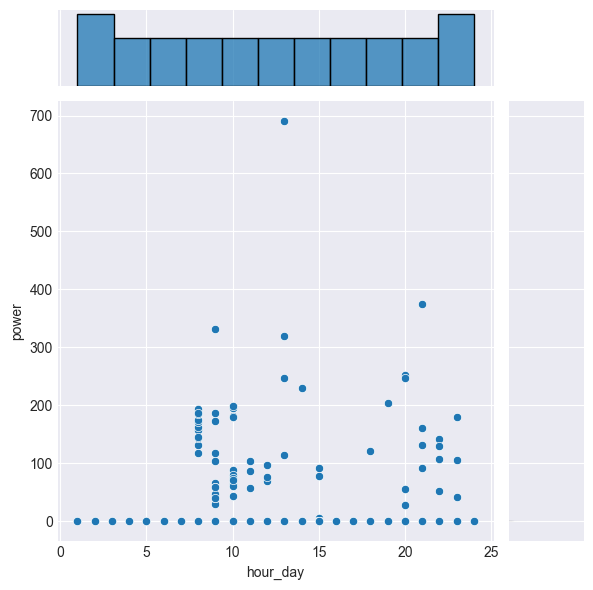

In [217]:
#corelation of all the features (on x-axis) with the target variable Energy (on y-axis) - after removing outliers and missing values
no_of_features=len(data.columns)
for j in range(1, no_of_features):
    sns.jointplot(x = data.columns[j], y = data.columns[0], data = data)

In [218]:
no_of_timesteps = 1
reframed = series_to_supervised(scaled1, no_of_timesteps, 1)
print(reframed.head())
print(reframed.shape)

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
241  -0.201608  -0.938397  -1.051974  -0.850707  -0.202848  -0.204811   
242  -0.201927  -0.938397  -1.051974  -0.850707  -0.202694  -0.204811   
243  -0.202504  -0.793928  -1.051974  -0.850707  -0.202514  -0.204811   
244  -0.201780  -0.793928  -1.051974  -0.850707   3.852655  -0.204811   
245  -0.201608  -0.649459  -1.051974  -0.850707  -0.203294  -0.204811   

     var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
241  -0.227017 -0.201927 -0.938397 -1.051974 -0.850707 -0.202694 -0.204811   
242  -0.219948 -0.202504 -0.793928 -1.051974 -0.850707 -0.202514 -0.204811   
243  -0.222375 -0.201780 -0.793928 -1.051974 -0.850707  3.852655 -0.204811   
244   4.880220 -0.201608 -0.649459 -1.051974 -0.850707 -0.203294 -0.204811   
245   0.668753 -0.202250 -0.649459 -1.051974 -0.850707  1.568361 -0.204811   

      var7(t)  
241 -0.219948  
242 -0.222375  
243  4.880220  
244  0.668753  
245  0.28556

In [219]:
n_train_time = 2*24*365;                                                             # hours used for training.....
original_n_train_time = n_train_time
pred_list = [];                                                                      #predicted values that will replace the original test_y values
testing_rows = 2*24*4                                                                #hours to predict

#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time : n_train_time + testing_rows, : ]              #original testing data, this will later be modified with the predicted data generated by for loop
test_y1 = test1[:, -1]                                                               #see comment in above line
batch_size_fit=1

In [220]:
train = reframed.values[:n_train_time, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], no_of_timesteps, no_of_features))
print(train_X.shape)

ValueError: cannot reshape array of size 15600 into shape (1200,1,2)

In [221]:
#LSTM model
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(LSTM(20, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

#adam = keras.optimizers.Adamax(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=batch_size_fit, verbose=2, shuffle=True)

IndexError: tuple index out of range